In [44]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [46]:
engine = create_engine("sqlite:///alaska_oil_data.db")
query = 'SELECT p.*, FROM production p WHERE {} LEFT JOIN location l ON p.Permit = l.PermitNumber;'

df_prod = pd.read_sql('''SELECT p.*, l.WellHeadLat, l.WellHeadLong
                                        FROM production p 
                                        LEFT JOIN location l ON p.API = l.APINumber
                                        WHERE p.pool = 'PRUDHOE OIL' AND lower(p.ProductionMethod) NOT LIKE '%shut%' ''', engine)
#df_inj = pd.read_sql(query.format("injection", "pool = 'PRUDHOE OIL' AND lower(InjectionType) NOT LIKE '%disposal%' AND lower(InjectionType) NOT LIKE '%storage%' AND lower(InjectionType) NOT LIKE '%shut%' AND lower(InjectionMethod) NOT LIKE '%shut%' AND lower(WellStatus) NOT LIKE '%abandon%'"), engine)


In [45]:
print(df_prod.shape)
df_prod.columns

(329530, 19)


Index(['Permit', 'API', 'WellName', 'Operator', 'WellStatus', 'Area', 'Field',
       'Pool', 'Pad', 'ProductionType', 'ProductionMethod', 'Oil', 'Gas',
       'Water', 'Days', 'WellHeadLat', 'WellHeadLong', 'Month', 'Field_start'],
      dtype='object')

In [47]:
df_prod['Month'] = pd.to_datetime(df_prod['Date'], format= '%m/%Y', utc=False)
df_prod.drop('Date', axis = 1, inplace = True)
df_prod['Field_start'] = df_prod['Month'].min()

#df_inj['Month'] = pd.to_datetime(df_inj['Date'], format= '%m/%Y')
#df_inj.drop('Date', axis = 1, inplace = True)

In [41]:
df_prod[df_prod['Month'] == df_prod['Month'].min()]

,Permit,API,WellName,Operator,WellStatus,Area,Field,Pool,Pad,ProductionType,ProductionMethod,Oil,Gas,Water,Days,WellHeadLat,WellHeadLong,Month,Field_start
329529,168023,50029200020000.0,SAG RIV ST 1,ARCO Alaska Inc.,Plugged & Abandoned,ARCTIC SLOPE,PRUDHOE BAY,PRUDHOE OIL,Unknown,Oil Production,Flowing,"6,096","4,950",6,6,70.254727,-148.342453,1969-04-01,1969-04-01


In [42]:
df_prod['Field_start']

0        1969-04-01
1        1969-04-01
2        1969-04-01
3        1969-04-01
4        1969-04-01
            ...    
329525   1969-04-01
329526   1969-04-01
329527   1969-04-01
329528   1969-04-01
329529   1969-04-01
Name: Field_start, Length: 329530, dtype: datetime64[ns]

In [48]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329530 entries, 0 to 329529
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Permit            329530 non-null  object        
 1   API               329530 non-null  object        
 2   WellName          329530 non-null  object        
 3   Operator          329530 non-null  object        
 4   WellStatus        329530 non-null  object        
 5   Area              329530 non-null  object        
 6   Field             329530 non-null  object        
 7   Pool              329530 non-null  object        
 8   Pad               329530 non-null  object        
 9   ProductionType    329530 non-null  object        
 10  ProductionMethod  329530 non-null  object        
 11  Oil               329530 non-null  object        
 12  Gas               329530 non-null  object        
 13  Water             329530 non-null  object        
 14  Days

In [49]:
if df_prod['Oil'].dtype == 'object':
    df_prod['Oil'] = df_prod['Oil'].str.replace(',','').fillna(0)
    df_prod['Oil'] = pd.to_numeric(df_prod['Oil'])
if df_prod['Gas'].dtype == 'object':
    df_prod['Gas'] = df_prod['Gas'].str.replace(',','').fillna(0)
    df_prod['Gas'] = pd.to_numeric(df_prod['Gas'])
if df_prod['Water'].dtype == 'object':
    df_prod['Water'] = df_prod['Water'].str.replace(',','').fillna(0)
    df_prod['Water'] = pd.to_numeric(df_prod['Water'])
#df_prod['Oil'] = pd.to_numeric(df_prod['Oil'], downcast = 'integer')




#df_inj['Gas'] = df_inj['Gas'].str.replace(',','').fillna(0)
#df_inj['Liquid'] = df_inj['Liquid'].str.replace(',','').fillna(0)
# df_inj['Gas'] = pd.to_numeric(df_inj['Gas'], downcast = 'integer')
# df_inj['Liquid'] = pd.to_numeric(df_inj['Liquid'], downcast = 'integer')

In [50]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329530 entries, 0 to 329529
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Permit            329530 non-null  object        
 1   API               329530 non-null  object        
 2   WellName          329530 non-null  object        
 3   Operator          329530 non-null  object        
 4   WellStatus        329530 non-null  object        
 5   Area              329530 non-null  object        
 6   Field             329530 non-null  object        
 7   Pool              329530 non-null  object        
 8   Pad               329530 non-null  object        
 9   ProductionType    329530 non-null  object        
 10  ProductionMethod  329530 non-null  object        
 11  Oil               329530 non-null  int64         
 12  Gas               329530 non-null  int64         
 13  Water             329530 non-null  int64         
 14  Days

In [51]:
df_prod['Oil_avg'] = df_prod['Oil']/df_prod['Days']
df_prod['Gas_avg'] = df_prod['Gas']/df_prod['Days']
df_prod['Water_avg'] = df_prod['Water']/df_prod['Days']
df_prod['Normalized_months'] = (df_prod['Month'].dt.year - df_prod['Field_start'].dt.year)*12 + (df_prod['Month'].dt.month - df_prod['Field_start'].dt.month)




In [52]:
df_prod_avg=df_prod.groupby('Normalized_months')[["Oil_avg", "Gas_avg", "Water_avg"]].sum().reset_index()
df_prod_avg.drop(df_prod_avg[df_prod_avg['Normalized_months']<0].index, inplace = True)
df_prod_avg = df_prod_avg.reset_index()
df_prod_avg.drop('index', axis = 1, inplace = True)

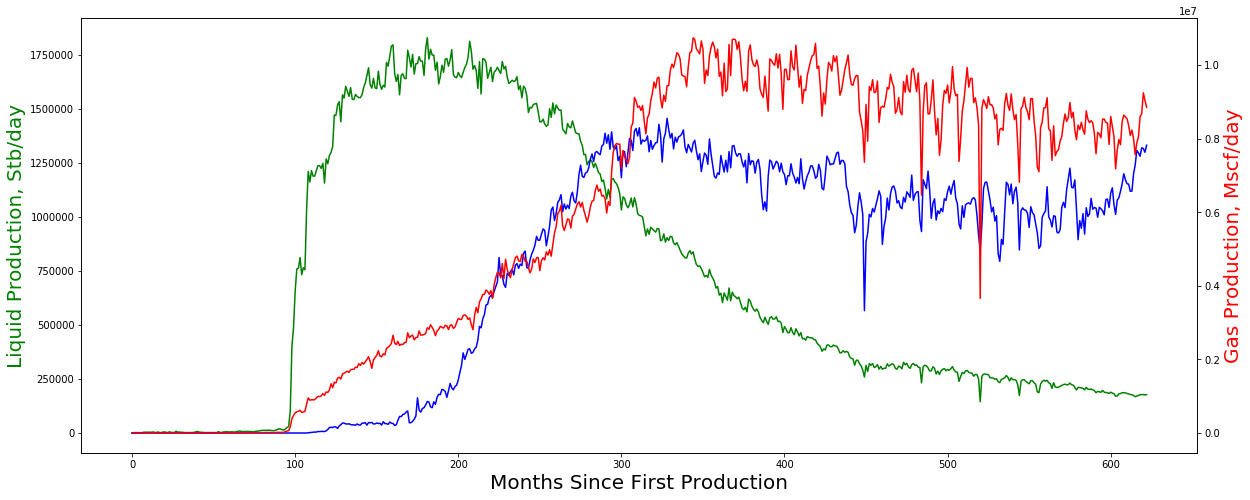

In [53]:
fig,ax = plt.subplots()
ax.plot(df_prod_avg['Normalized_months'], df_prod_avg['Oil_avg'], color="green")
ax.plot(df_prod_avg['Normalized_months'], df_prod_avg['Water_avg'], color = "blue")
ax.set_xlabel("Months Since First Production",fontsize=20)
ax.set_ylabel("Liquid Production, Stb/day",color="green",fontsize=20)
ax2=ax.twinx()
ax2.plot(df_prod_avg['Normalized_months'], df_prod_avg['Gas_avg'],color="red")
ax2.set_ylabel("Gas Production, Mscf/day",color="red",fontsize=20)
fig.set_size_inches(20, 8)

In [54]:
Cum_oil = df_prod_avg['Oil_avg'].sum()*30.44
Cum_gas = df_prod_avg['Gas_avg'].sum()*30.44
Cum_water = df_prod_avg['Water_avg'].sum()*30.44

In [55]:
df_prod_avg['Watercut'] = df_prod_avg['Water_avg']/(df_prod_avg['Water_avg']+ df_prod_avg['Oil_avg'])
df_prod_avg['GOR'] = df_prod_avg['Gas_avg']*1000 / df_prod_avg['Oil_avg']

In [56]:
df_prod_avg

,Normalized_months,Oil_avg,Gas_avg,Water_avg,Watercut,GOR
0,0,1016.000000,8.250000e+02,0.000000e+00,0.000000,812.007874
1,2,2243.571429,2.580143e+03,0.000000e+00,0.000000,1150.015918
2,6,1607.157895,1.354316e+03,0.000000e+00,0.000000,842.677495
3,7,3720.666667,3.034200e+03,0.000000e+00,0.000000,815.499015
4,8,3911.034483,3.558172e+03,0.000000e+00,0.000000,909.777817
...,...,...,...,...,...,...
614,618,177856.370691,8.600875e+06,1.280038e+06,0.878005,48358.545911
615,619,177541.415867,8.682717e+06,1.319032e+06,0.881368,48905.305403
616,620,177781.484943,9.250671e+06,1.315636e+06,0.880957,52033.939234
617,621,176214.240532,9.042356e+06,1.298201e+06,0.880485,51314.561554


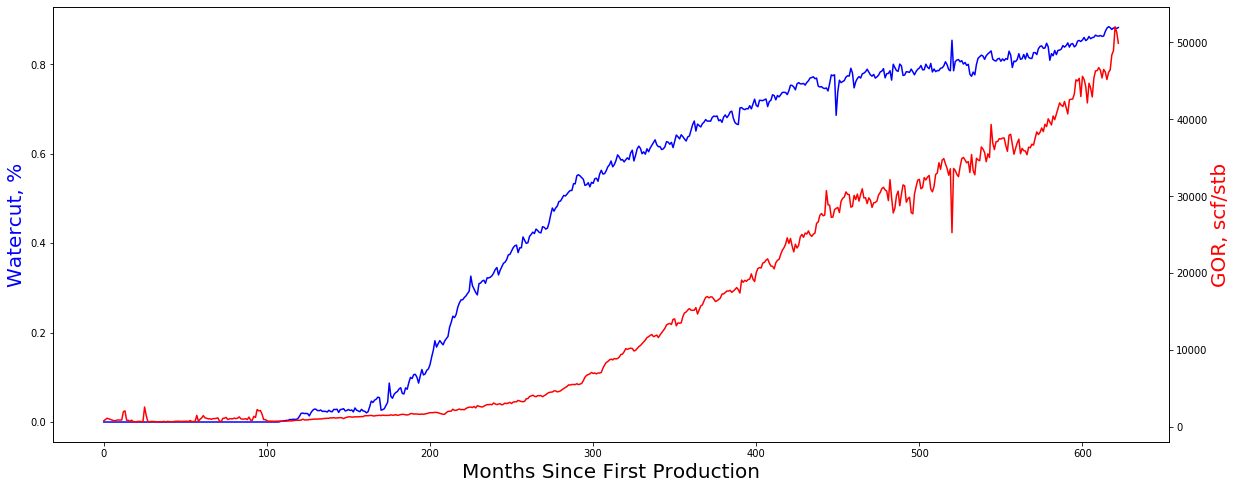

In [57]:
fig,ax = plt.subplots()
ax.plot(df_prod_avg['Normalized_months'], df_prod_avg['Watercut'], color = "blue")
ax.set_xlabel("Months Since First Production",fontsize=20)
ax.set_ylabel("Watercut, %",color="blue",fontsize=20)
ax2=ax.twinx()
ax2.plot(df_prod_avg['Normalized_months'], df_prod_avg['GOR'],color="red")
ax2.set_ylabel("GOR, scf/stb",color="red",fontsize=20)
fig.set_size_inches(20, 8)

In [58]:
df_prod_cum = df_prod_avg[['Normalized_months']]

In [59]:
df_prod_cum['Oil_cum']= df_prod_avg['Oil_avg'].cumsum()
df_prod_cum['Gas_cum']= df_prod_avg['Gas_avg'].cumsum()
df_prod_cum['Water_cum']= df_prod_avg['Water_avg'].cumsum()

/Users/matthewdupree/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/matthewdupree/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/matthewdupree/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

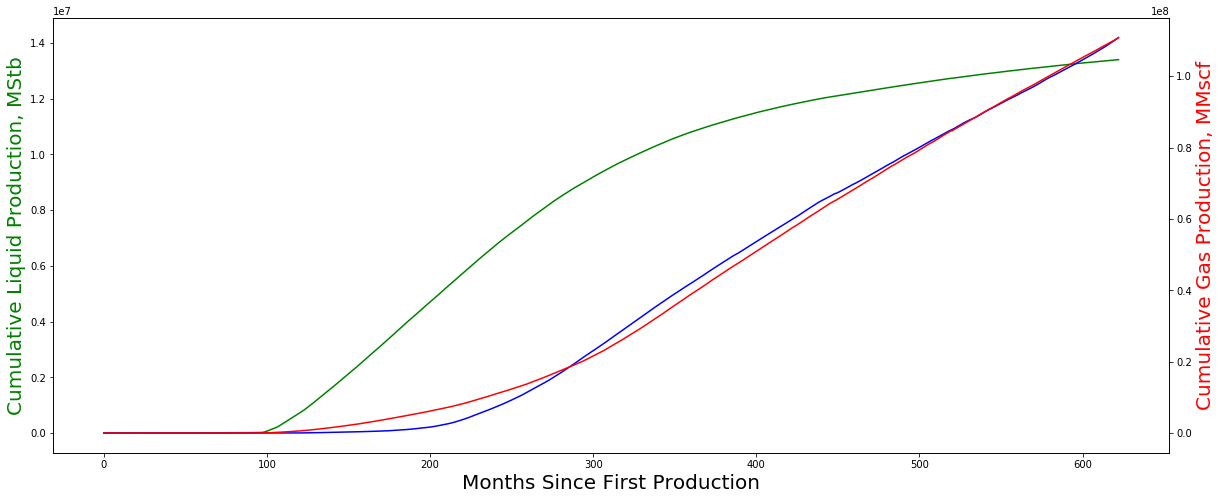

In [60]:
fig,ax = plt.subplots()
ax.plot(df_prod_cum['Normalized_months'], df_prod_cum['Oil_cum']/1000*30.44, color="green")
ax.plot(df_prod_cum['Normalized_months'], df_prod_cum['Water_cum']/1000*30.44, color = "blue")
ax.set_xlabel("Months Since First Production",fontsize=20)
ax.set_ylabel("Cumulative Liquid Production, MStb",color="green",fontsize=20)
ax2=ax.twinx()
ax2.plot(df_prod_cum['Normalized_months'], df_prod_cum['Gas_cum']/1000*30.44,color="red")
ax2.set_ylabel("Cumulative Gas Production, MMscf",color="red",fontsize=20)
fig.set_size_inches(20, 8)

In [63]:
df_prod_cum.Oil_cum.max()

440226507.73452365

In [ ]:
def exponential_equation(t, qi, di):
    return qi*np.exp(-di*t)

def hyperbolic_equation(t, qi, b, di):
    return qi/((1.0+b*di*t)**(1.0/b))

def hyperbolic_equation(t, qi, di):
    return qi/(1.0+di*t)

In [ ]:
df_prod_avg

In [ ]:
def get_max_for_decline (df):
    split_size = round(len(df_prod_avg)/20)
    split_list = []
    split1 = df.loc[0:split_size-1]
    split_list.append(split1[split1['Oil_avg'] == split1.Oil_avg.max()][['Normalized_months','Oil_avg']])
    split2 =df.loc[split_size:2*split_size-1]
    split_list.append(split2[split2['Oil_avg'] == split2.Oil_avg.max()][['Normalized_months','Oil_avg']])
    split3 =df.loc[2*split_size:3*split_size-1]
    split_list.append(split3[split3['Oil_avg'] == split3.Oil_avg.max()][['Normalized_months','Oil_avg']])
    split4 =df.loc[3*split_size:4*split_size-1]
    split_list.append(split4[split4['Oil_avg'] == split4.Oil_avg.max()][['Normalized_months','Oil_avg']])
    split5 =df.loc[4*split_size:5*split_size-1]
    split_list.append(split5[split5['Oil_avg'] == split5.Oil_avg.max()][['Normalized_months','Oil_avg']])
    split6 =df.loc[5*split_size:6*split_size-1]
    split_list.append(split6[split6['Oil_avg'] == split6.Oil_avg.max()][['Normalized_months','Oil_avg']])
    split7 =df.loc[6*split_size:7*split_size-1]
    split_list.append(split7[split7['Oil_avg'] == split7.Oil_avg.max()][['Normalized_months','Oil_avg']])
    split8 =df.loc[7*split_size:8*split_size-1]
    split_list.append(split8[split8['Oil_avg'] == split8.Oil_avg.max()][['Normalized_months','Oil_avg']])
    split9 =df.loc[8*split_size:9*split_size-1]
    split_list.append(split9[split9['Oil_avg'] == split9.Oil_avg.max()][['Normalized_months','Oil_avg']])
    splitend =df.loc[9*split_size:]
    split_list.append(splitend[splitend['Oil_avg'] == splitend.Oil_avg.max()][['Normalized_months','Oil_avg']])
    
    diff_list = list([float(j['Oil_avg']) - float(i['Oil_avg']) for i, j in zip(split_list, split_list[1:])])
    neg_indices = [i for i, val in enumerate(diff_list) if val < 0]
    for i in range(len(neg_indices)):
        if neg_indices[i+1]-neg_indices[i] == 1 and neg_indices [i+2]- neg_indices[i+1] == 1:
            return int(split_list[neg_indices[i+2]]['Normalized_months']), float(split_list[neg_indices[i+2]]['Oil_avg'])
    

In [ ]:
get_max_for_decline(df_prod_avg)

In [ ]:
#Get the highest value of production in the first three months of production, to use as qi value
qi_month, qi=get_max_for_decline(df_prod_avg)

#Exponential curve fit the data to get best fit equation
popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['Days_Online'], production_time_series[desired_product_type],bounds=(0, [qi,20]))
print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))

#Hyperbolic curve fit the data to get best fit equation
popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['Days_Online'], production_time_series[desired_product_type],bounds=(0, [qi,2,20]))
print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))

In [ ]:
fig,ax = plt.subplots()
ax.plot(df_prod_avg['Normalized_months'], df_prod_avg['Oil_avg'], color="green")
ax.axvline(x=qi_month, ymin=-1, ymax=0.95, color = 'black',ls = ':')
ax.set_xlabel("Months Since First Production",fontsize=20)
ax.set_ylabel("Liquid Production, Stb/day",color="green",fontsize=20)
fig.set_size_inches(20, 8)

In [ ]:
def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
    """
    This function is used to map x- and y-variables against each other
    Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
    """
    #Plot results
    df.plot(x=x_variable, y=y_variables, title=plot_title)
    plt.show()

In [ ]:
#Declare the x- and y- variables that we want to plot against each other
y_variables=[desired_product_type, "Hyperbolic_Predicted", "Exponential_Predicted"]
x_variable='Days_Online'
#Create the plot title
plot_title=desired_product_type+' Production for Well API '+str(api_number)
#Plot the data to visualize the equation fit
plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)

In [ ]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

def read_in_csv(file_path):
    """
    Read in the specified csv as a pandas dataframe
    Arguments: 
        file_path: String. Path for the csv file that we want to read in
    Outputs:
        dataframe: Pandas dataframe.
    """
    dataframe=pd.read_csv(file_path)
    return dataframe

def hyperbolic_equation(t, qi, b, di):
    """
    Hyperbolic decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi/((1.0+b*di*t)**(1.0/b))

def exponential_equation(t, qi, di):
    """
    Exponential decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi*np.exp(-di*t)

def remove_nan_and_zeroes_from_columns(df, variable):
    """
    This function cleans up a dataframe by removing rows in a specific 
    column that are null/NaN or equal to 0. This basically removes zero 
    production time periods.
    Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
    Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
    """
    filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
    return filtered_df

def generate_time_delta_column(df, time_column, date_first_online_column):
    """
    Create column for the time that a well has been online at each reading, with 
    the first non-null month in the series listed as the start of production
    Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
    Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
    """
    return (df[time_column]-df[date_first_online_column]).dt.days
    
def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
    """
    This function obtains the min or max value for a column, with a group by applied. For example,
    it could return the earliest (min) RecordDate for each API number in a dataframe 
    Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
    Outputs:
        value: Depends on the calc_column type.
    """
    value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
    return value

def get_max_initial_production(df, number_first_months, variable_column, date_column):
    """
    This function allows you to look at the first X months of production, and selects 
    the highest production month as max initial production
    Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
    """
    #First, sort the data frame from earliest to most recent prod date
    df=df.sort_values(by=date_column)
    #Pull out the first x months of production, where number_first_months is x
    df_beginning_production=df.head(number_first_months)
    #Return the max value in the selected variable column from the newly created 
    #df_beginning_production df
    return df_beginning_production[variable_column].max()

def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
    """
    This function is used to map x- and y-variables against each other
    Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
    """
    #Plot results
    df.plot(x=x_variable, y=y_variables, title=plot_title)
    plt.show()

def main():
    #Read in the monthly oil and gas data
    file_path='master_dataframe_production.csv'
    bakken_data=read_in_csv(file_path)
    #Perform some data cleaning to get the columns as the right data type
    bakken_data['ReportDate']=pd.to_datetime(bakken_data['ReportDate'])
    #Declare the desired product that we want to curve fit for--it can either by 'Gas' or 'Oil'
    desired_product_type='Oil'
    #Remove all rows with null values in the desired time series column
    bakken_data=remove_nan_and_zeroes_from_columns(bakken_data, desired_product_type)
    #Get the earliest RecordDate for each API Number
    bakken_data['Online_Date']= get_min_or_max_value_in_column_by_group(bakken_data, group_by_column='API_WELLNO', 
                  calc_column='ReportDate', calc_type='min')
    #Generate column for time online delta
    bakken_data['Days_Online']=generate_time_delta_column(bakken_data, time_column='ReportDate', 
                  date_first_online_column='Online_Date')
    #Pull data that came online between January and June 2016
    bakken_data_2016=bakken_data[(bakken_data.Online_Date>='2016-01-01') & (bakken_data.Online_Date<='2016-06-01')]
    #Get a list of unique API's to loop through--these were randomly selected as examples
    unique_well_APIs_list=[33023013930000.0, 33105039980000.0, 33105039970000.0, 
                           33013018230000.0, 33013018220000.0]
    #Loop through each API, and perform calculations
    for api_number in unique_well_APIs_list:
        #Subset the dataframe by API Number
        production_time_series=bakken_data_2016[bakken_data_2016.API_WELLNO==api_number]
        #Get the highest value of production in the first three months of production, to use as qi value
        qi=get_max_initial_production(production_time_series, 3, desired_product_type, 'ReportDate')
        #Exponential curve fit the data to get best fit equation
        popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['Days_Online'], 
                                     production_time_series[desired_product_type],bounds=(0, [qi,20]))
        print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))
        #Hyperbolic curve fit the data to get best fit equation
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['Days_Online'], 
                                     production_time_series[desired_product_type],bounds=(0, [qi,2,20]))
        print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Exponential fit results
        production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['Days_Online'], 
                                  *popt_exp)
        #Hyperbolic fit results
        production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['Days_Online'], 
                                  *popt_hyp)
        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[desired_product_type, "Hyperbolic_Predicted", "Exponential_Predicted"]
        x_variable='Days_Online'
        #Create the plot title
        plot_title=desired_product_type+' Production for Well API '+str(api_number)
        #Plot the data to visualize the equation fit
        plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)
                
if __name__== "__main__":
    main()